# Sequence Processing with HMMs and CRFs

**The goal of this practical is to study sequence models in NLP.**

We will work on Part-Of-Speech (POS) and optionally on chunking (gathering different groups in sentences). The datasets are from [CONLL 2000](https://www.clips.uantwerpen.be/conll2000/chunking/): 
- **Small corpus:** chtrain/chtest to understand the tools and models 
- **Larger corpus:** train/test to collect reliable experimental results


# 1) HMMS


In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Loading POS/Chunking data
def load(filename):
    listeDoc = list()
    with open(filename, "r") as f:
        doc = list()
        for ligne in f:
            if len(ligne) < 2: # fin de doc
                listeDoc.append(doc)
                doc = list()
                continue
            mots = ligne.replace("\n","").split(" ")
            doc.append((mots[0],mots[1])) # Change mots[1] -> mots[2] for chuncking
    return listeDoc

In [3]:
# =============== loding ============
# small corpus => ideal for first tests
filename = "ressources/conll2000/chtrain.txt" 
filenameT = "ressources/conll2000/chtest.txt" 

# Larger corpus => To valide perf.
# filename = "ressources/conll2000/train.txt" 
# filenameT = "ressources/conll2000/test.txt" 

alldocs = load(filename)
alldocsT = load(filenameT)

print(len(alldocs)," docs read")
print(len(alldocsT)," docs (T) read")

823  docs read
77  docs (T) read


In [4]:
print(alldocs[0])
print(alldocsT[0])

[('Rockwell', 'NNP'), ('International', 'NNP'), ('Corp.', 'NNP'), ("'s", 'POS'), ('Tulsa', 'NNP'), ('unit', 'NN'), ('said', 'VBD'), ('it', 'PRP'), ('signed', 'VBD'), ('a', 'DT'), ('tentative', 'JJ'), ('agreement', 'NN'), ('extending', 'VBG'), ('its', 'PRP$'), ('contract', 'NN'), ('with', 'IN'), ('Boeing', 'NNP'), ('Co.', 'NNP'), ('to', 'TO'), ('provide', 'VB'), ('structural', 'JJ'), ('parts', 'NNS'), ('for', 'IN'), ('Boeing', 'NNP'), ("'s", 'POS'), ('747', 'CD'), ('jetliners', 'NNS'), ('.', '.')]
[('Confidence', 'NN'), ('in', 'IN'), ('the', 'DT'), ('pound', 'NN'), ('is', 'VBZ'), ('widely', 'RB'), ('expected', 'VBN'), ('to', 'TO'), ('take', 'VB'), ('another', 'DT'), ('sharp', 'JJ'), ('dive', 'NN'), ('if', 'IN'), ('trade', 'NN'), ('figures', 'NNS'), ('for', 'IN'), ('September', 'NNP'), (',', ','), ('due', 'JJ'), ('for', 'IN'), ('release', 'NN'), ('tomorrow', 'NN'), (',', ','), ('fail', 'VB'), ('to', 'TO'), ('show', 'VB'), ('a', 'DT'), ('substantial', 'JJ'), ('improvement', 'NN'), ('from'

## Building a baseline POS model (without sequence)

We will build a simple dictionary ```word => PoS label``` without taking into account any sequence information. We will compare the sequence models to this baseline.

The dataset is a list a tuples with ```(word, POS)```. **Build a simple dictionary mapping each word to its PoS tag in the train set**

In [5]:
# Dictionary building 
dico = dict()
# YOUR CODE HERE
for ligne in alldocs:
  for word,PoS in ligne:
    if word not in dico:
      dico[word] = dict()
    if PoS not in dico[word]:
      if PoS not in dico[word]:
        dico[word][PoS] = 0
      dico[word][PoS] += 1
print(dico['said'])

{'VBD': 1}


In [9]:
dico_max = dict() # à chaque mot son PoS le plus fréquent
for word in dico:
  d_PoS = dico[word]
  PoS_m,v_m = 'xyz',0
  for PoS in d_PoS:
    if d_PoS[PoS] > v_m:
      PoS_m = PoS
      v_m = d_PoS[PoS]
  dico_max[word] = PoS

dico_max['a']

'DT'

**Note: on the test set, there are unknown words...**. We will use the following simple strategy: 
```
# remplace
dico[cle] # crashing with an unknown key 
# by 
dico.get(cle, DefaultValue)
```
From a linguistic point of view, we can choose the default value as the majority PoS class, producing a stronger baseline.

In [10]:
# Evaluate test performances

# TODO
DefaultValue = 'NN'
n_default = 0
cont,n = 0,0
for ligne in alldocsT:
  for word,PoS in ligne:
    if word not in dico_max:
      dico_max[word] = DefaultValue
      n_default += 1
    y_PoS = dico_max[word]
    if y_PoS == PoS:
      cont += 1 # bonne prediction
    n += 1

print('Check:',cont,'good predictions in test over',n)
print(f"({n_default} with 'NN' as default PoS value)")

Check: 1365 good predictions in test over 1896
(261 with 'NN' as default PoS value


Check: 1433 good predictions in test over 1896

(1527 with 'NN' as default PoS value)

## HMMs

Here is a code for training HMM parameters and running decoding using the Viterbi algorithm. You should apply it to our PoS task. **N.B.: you should undersand the ```eps``` parmaters**.


In [11]:
# allx: list of observation sequences 
# allq: list os state sequences 
# N: nb states
# K: nb observations

def learnHMM(allx, allq, N, K, initTo1=True):
    if initTo1:
        eps = 1e-3 # You can play with this regularization parameter 
        A = np.ones((N,N))*eps
        B = np.ones((N,K))*eps
        Pi = np.ones(N)*eps
    else:
        A = np.zeros((N,N))
        B = np.zeros((N,K))
        Pi = np.zeros(N)
    for x,q in zip(allx,allq):
        Pi[int(q[0])] += 1
        for i in range(len(q)-1):
            A[int(q[i]),int(q[i+1])] += 1
            B[int(q[i]),int(x[i])] += 1
        B[int(q[-1]),int(x[-1])] += 1 # last transition
    A = A/np.maximum(A.sum(1).reshape(N,1),1) # normalisation
    B = B/np.maximum(B.sum(1).reshape(N,1),1) # normalisation
    Pi = Pi/Pi.sum()
    return Pi , A, B

def viterbi(x,Pi,A,B):
    T = len(x)
    N = len(Pi)
    logA = np.log(A)
    logB = np.log(B)
    logdelta = np.zeros((N,T))
    psi = np.zeros((N,T), dtype=int)
    S = np.zeros(T)
    logdelta[:,0] = np.log(Pi) + logB[:,int(x[0])]
    #forward
    for t in range(1,T):
        logdelta[:,t] = (logdelta[:,t-1].reshape(N,1) + logA).max(0) + logB[:,int(x[t])]
        psi[:,t] = (logdelta[:,t-1].reshape(N,1) + logA).argmax(0)
    # backward
    logp = logdelta[:,-1].max()
    S[T-1] = logdelta[:,-1].argmax()
    for i in range(2,T+1):
        S[int(T-i)] = psi[int(S[int(T-i+1)]),int(T-i+1)]
    return S, logp #, delta, psi
 

### Data encoding

We will map each word to an index for traing the HMM (see code below):
```
 The cat is in the garden => 1 2 3 4 1 5
```
We have to understand the dictionary functionning to retrieve the words corresponding to indices.

In [12]:
# alldocs etant issu du chargement des données
# la mise en forme des données est fournie ici
# afin de produire des analyses qualitative, vous devez malgré tout comprendre le fonctionnement des dictionnaires

buf = [[m for m,pos in d ] for d in alldocs]
mots = []
[mots.extend(b) for b in buf]
mots = np.unique(np.array(mots))
nMots = len(mots)+1 # mot inconnu

mots2ind = dict(zip(mots,range(len(mots))))
mots2ind["UUUUUUUU"] = len(mots)

buf2 = [[pos for m,pos in d ] for d in alldocs]
cles = []
[cles.extend(b) for b in buf2]
cles = np.unique(np.array(cles))
cles2ind = dict(zip(cles,range(len(cles))))

nCles = len(cles)

print(nMots,nCles," in the dictionary")

# mise en forme des données
allx  = [[mots2ind[m] for m,pos in d] for d in alldocs]
allxT = [[mots2ind.setdefault(m,len(mots)) for m,pos in d] for d in alldocsT]

allq  = [[cles2ind[pos] for m,pos in d] for d in alldocs]
allqT = [[cles2ind.setdefault(pos,len(cles)) for m,pos in d] for d in alldocsT]

4570 42  in the dictionary


In [13]:
# First doc:
print(allx[0])
print(allq[0])

[1140, 814, 563, 11, 1294, 4393, 3855, 2854, 3992, 1362, 4242, 1452, 2395, 2855, 1990, 4529, 446, 525, 4299, 3595, 4148, 3368, 2499, 446, 11, 283, 2861, 20]
[18, 18, 18, 22, 18, 17, 32, 23, 32, 9, 13, 17, 33, 24, 17, 12, 18, 18, 29, 31, 13, 20, 12, 18, 22, 8, 20, 5]


## You turn: apply HMMs to those data!

In [14]:
# HMM training 
# YOUR CODE HERE
Pi, A, B = learnHMM(allx, allq, nCles, nMots)

In [15]:
# HMM decoding and performances evaluation
# YOUR CODE HERE
cont,n = 0,0
for i in range(len(allxT)):
  x,y = allxT[i],allqT[i]
  l_PoS = viterbi(x,Pi,A,B)
  # print(y)
  # print(l_PoS[0])
  # print(np.sum(l_PoS[0]==y))
  cont += np.sum(l_PoS[0]==y)
  n += len(y)

print('Check:',cont,'good predictions in test over',n)
#

Check: 1538 good predictions in test over 1896


Check : 1564 in test

### Qualitative Analyis:

- With imshow on the parameters (ou d'un argsort), show what are the probable transition between labels.
- Visualize the confusion matrices to understand what is challenging in this task
- Find out examples that are corrected by Viterbi decoding



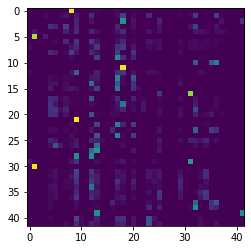

In [18]:
plt.imshow(A)

In [22]:
for k in zip([2,3],[4,5],[6,7]):
  print(k)

(2, 4, 6)
(3, 5, 7)


In [30]:
# exemples corrigés par viterbi
vit_cor = []
for i in range(len(allxT)):
  x,y = allxT[i],allqT[i]
  l_PoS = viterbi(x,Pi,A,B)
  # print(y)
  # print(l_PoS[0])
  # print(np.sum(l_PoS[0]==y))
  for xi,yi,pos in zip(x,y,l_PoS[0]):
    y1 = DefaultValue if xi not in dico_max else dico_max[xi]
    y1 = cles2ind[y1]
    pos = int(pos)
    if pos==yi and y1!=yi:
      vit_cor.append((xi,yi))

print('Exemples corrigés par viterbi:',len(vit_cor))

Exemples corrigés par viterbi: 1340


# 2) Conditional Random Fields (CRF)

**CRF are disciminative models** representing the conditional distribution $P( \mathbf{y} | \mathbf{x} , \mathbf{w})$:

$$ P( \mathbf{y} | \mathbf{x} , \mathbf{w})  = \frac{e^{\mathbf{w}^T  \psi(\mathbf{x},\mathbf{y}) } }{\sum\limits_{y' \in \mathcal{y}}e^{\mathbf{w}^T  \psi(\mathbf{x},\mathbf{y}') } } $$ 
        
**In 'linear-chain' CRFs**, the feature functions include **unary terms $u_k$** ($\sim$ $\mathbf{B}$ matrix in HMMs) and **pairwise terms $p_k$** ($\sim$ $\mathbf{A}$ matrix in HMMs):

$$ \psi(\mathbf{x},\mathbf{y}) = \sum\limits_{t=1}^T \sum_{k=1}^K F_k(y_{t-1}, y_t, \mathbf{x})  =   \sum\limits_{t=1}^T \sum_{k=1}^K \left[ u_k(y_t, \mathbf{x}) + p_k(y_{t-1}, y_t, \mathbf{x}) \right]$$

[<img src="https://thome.isir.upmc.fr/classes/RITAL/crf-obs2.png" width="800" >](https://thome.isir.upmc.fr/classes/RITAL/crf-obs2.png)


We can directly use resources from nltk: 
- [CRFTagger](https://tedboy.github.io/nlps/generated/generated/nltk.CRFTagger.html)
- [PerceptronTagger](https://www.nltk.org/_modules/nltk/tag/perceptron.html)

In [47]:
# !pip install python-crfsuite
from nltk.tag.crf import CRFTagger
tagger = CRFTagger()
tagger.train(alldocs, 'crf.model') # training

# TO DO
bufT = [[m for m,pos in d ] for d in alldocsT]

pred = tagger.tag_sents(bufT) # prediction
print(pred)

# evaluation de test
print("Taux d'évaluation:",tagger.evaluate(alldocsT))

[[('Confidence', 'NNP'), ('in', 'IN'), ('the', 'DT'), ('pound', 'NN'), ('is', 'VBZ'), ('widely', 'RB'), ('expected', 'VBN'), ('to', 'TO'), ('take', 'VB'), ('another', 'DT'), ('sharp', 'JJ'), ('dive', 'NN'), ('if', 'IN'), ('trade', 'NN'), ('figures', 'NNS'), ('for', 'IN'), ('September', 'NNP'), (',', ','), ('due', 'JJ'), ('for', 'IN'), ('release', 'DT'), ('tomorrow', 'NN'), (',', ','), ('fail', 'NN'), ('to', 'TO'), ('show', 'VB'), ('a', 'DT'), ('substantial', 'JJ'), ('improvement', 'NN'), ('from', 'IN'), ('July', 'NNP'), ('and', 'CC'), ('August', 'NNP'), ("'s", 'POS'), ('near-record', 'NN'), ('deficits', 'NNS'), ('.', '.')], [('Chancellor', 'NNP'), ('of', 'IN'), ('the', 'DT'), ('Exchequer', 'NNP'), ('Nigel', 'NNP'), ('Lawson', 'NNP'), ("'s", 'POS'), ('restated', 'JJ'), ('commitment', 'NN'), ('to', 'TO'), ('a', 'DT'), ('firm', 'NN'), ('monetary', 'NN'), ('policy', 'NN'), ('has', 'VBZ'), ('helped', 'VBN'), ('to', 'TO'), ('prevent', 'VB'), ('a', 'DT'), ('freefall', 'NN'), ('in', 'IN'), ('s

/var/folders/x7/bmqxr1zd3lxd_kcxxw9physr0000gn/T/ipykernel_2297/1324122420.py:15: DeprecationWarning: 
  Function evaluate() has been deprecated.  Use accuracy(gold)
  instead.
  print("Taux d'évaluation:",tagger.evaluate(alldocsT))


### Training and evaluating the model, as before

Check: 1720 bonnes réponses

In [54]:
# perceptron
from nltk.tag.perceptron    import PerceptronTagger
tagger = PerceptronTagger(load=False)
tagger.train(alldocs)
taux = tagger.evaluate(alldocsT)
print("Taux d'évaluation:",taux) 
bufT = [[m for m,pos in d ] for d in alldocsT]
bu = []
[bu.extend(b) for b in bufT]
print("Check:", int(taux*len(bu)))


Taux d'évaluation: 0.919831223628692
Check: 1744


/var/folders/x7/bmqxr1zd3lxd_kcxxw9physr0000gn/T/ipykernel_2297/1669067953.py:5: DeprecationWarning: 
  Function evaluate() has been deprecated.  Use accuracy(gold)
  instead.
  taux = tagger.evaluate(alldocsT)


Check: 1737 bonnes réponses

# Going further

- We test the application for PoS, we can run similar experiments for chunking (see parsing indication, very simple to load data)
- Run  experiement on the larger dataset. This dataset is still largely used in research. This work can thus be included in your resume :)
- Work will be purshed with word embeddings (next practical), and for [NER](https://www.clips.uantwerpen.be/conll2003/ner/) with RNNs (X. Tannier)
- [State-of-the-art resources](https://github.com/stanfordnlp/stanza/)